In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [2]:
data_path = 'data/'
images = 'images/'

In [3]:
droids_df = pd.read_pickle(f'{data_path}droids_df.pkl')

In [4]:
droids_df

,class,fileName,height,width,xmax,xmin,ymax,ymin,is_train,category
0,bb8,BB-8_1,512,288,208,46,512,15,False,1
1,bb8,BB-8_2,432,634,401,196,425,143,False,1
2,bb8,BB-8_3,480,480,443,23,480,155,True,1
3,bb8,BB-8_4,480,480,480,18,479,1,False,1
4,bb8,BB-8_5,332,800,442,332,332,208,True,1
...,...,...,...,...,...,...,...,...,...,...
197,r2d2,R2-D2_97,306,656,318,198,284,47,True,2
198,r2d2,R2-D2_98,381,545,274,4,380,4,True,2
199,r2d2,R2-D2_99,617,1084,547,365,447,206,True,2
200,r2d2,R2-D2_100,383,900,436,240,382,212,False,2


In [5]:
num_classes = 2
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [6]:
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [7]:
x, y, f = [], [], []
for fileName, is_train in droids_df[['fileName', 'is_train']].values:
    droids_rects = droids_df.loc[droids_df['fileName'] == fileName]
    rects_data = droids_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{images}{fileName}.jpg')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(int(category) - 1)

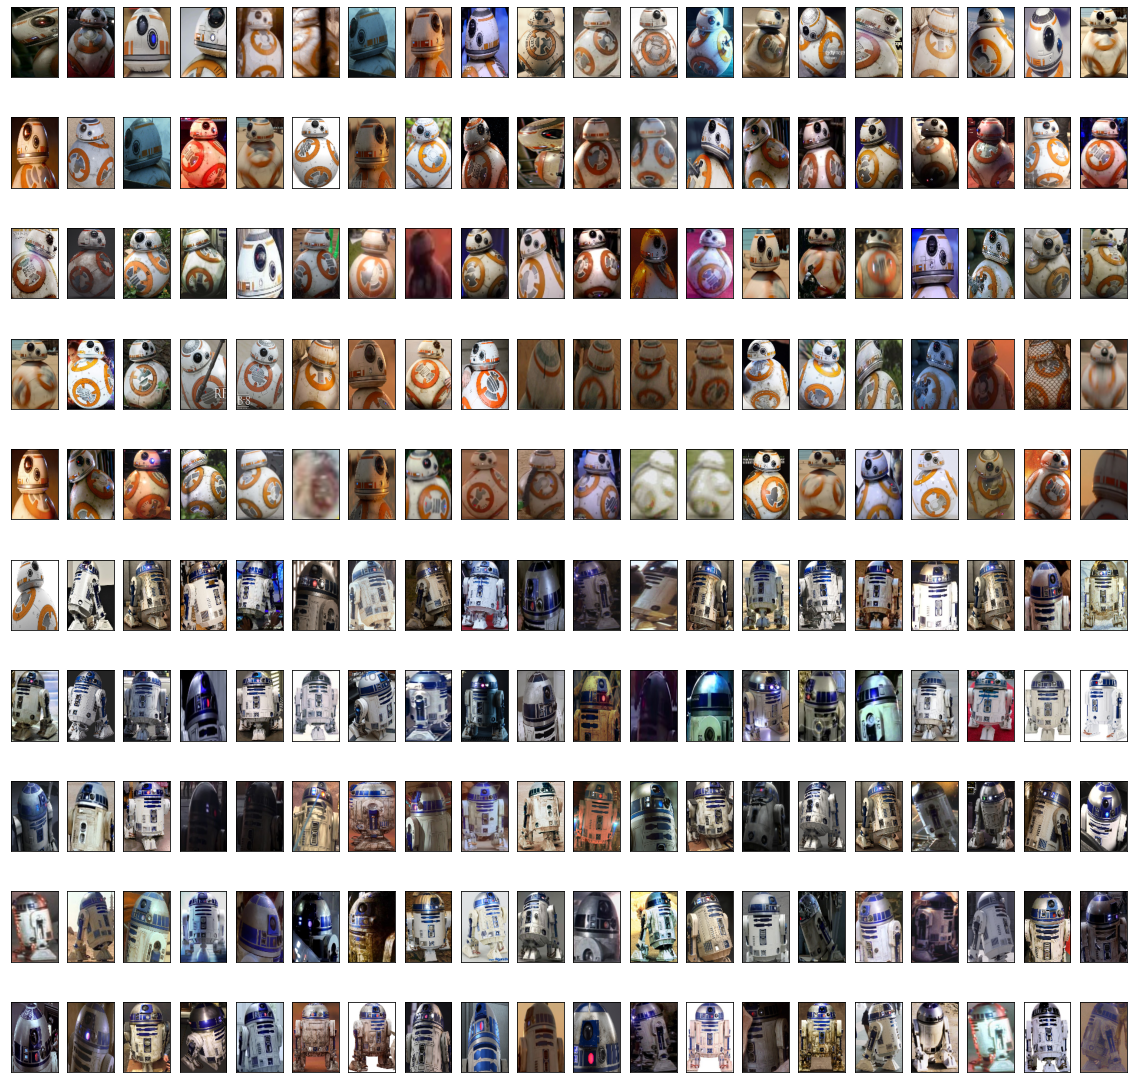

In [8]:
plt.figure(figsize=(20,20))
for i in range(200):
    plt.subplot(10,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[i], cmap=plt.cm.binary)
plt.show()

In [9]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_test, y_train, y_test = x[f], x[~f], y[f], y[~f]
# save test images
x_test_images = x_test

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (161, 120, 80, 3)
y_train shape: (161, 2)
161 train samples
41 test samples


In [13]:
def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 5:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr
    return 0.0005


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=2):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 80, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 80, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 80, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 80, 16)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [15]:
batch_size = 30
epochs = 20
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/20
6/6 [==============================] - 18s 3s/step - loss: 0.9194 - accuracy: 0.6770
Epoch 2/20
6/6 [==============================] - 14s 2s/step - loss: 0.5100 - accuracy: 0.8509
Epoch 3/20
6/6 [==============================] - 13s 2s/step - loss: 0.4184 - accuracy: 0.8882
Epoch 4/20
6/6 [==============================] - 14s 2s/step - loss: 0.3196 - accuracy: 0.9255
Epoch 5/20
6/6 [==============================] - 15s 2s/step - loss: 0.3442 - accuracy: 0.9379
Epoch 6/20
6/6 [==============================] - 14s 2s/step - loss: 0.2529 - accuracy: 0.9689
Epoch 7/20
6/6 [==============================] - 15s 2s/step - loss: 0.2265 - accuracy: 0.9876
Epoch 8/20
6/6 [==============================] - 16s 3s/step - loss: 0.2050 - accuracy: 0.9814
Epoch 9/20
6/6 [==============================] - 14s 2s/step - loss: 0.1989 - accuracy: 1.0000
Epoch 10/20
6/6 [==============================] - 13s 2s/step - loss: 0.2137 - accuracy: 0.9752
Epoch 11/20
6/6 [======================

In [16]:
# predictions = model.predict(x_test)

# class_names = np.array(['bb8','r2d2', 'none'])
# for i in range(len(x_test)):
#     plt.imshow(x_test[i], cmap=plt.cm.binary)
#     print(round(predictions[i][0], 4), round(predictions[i][1], 4), round(predictions[i][2], 4))
        
#     if predictions[i][0] == max(predictions[i]):
#         plt.xlabel(class_names[0])
#     elif predictions[i][1] == max(predictions[i]): plt.xlabel(class_names[1])
#     else: plt.xlabel(class_names[2])

#     plt.show()

In [17]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', acc)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

41/41 [==============================] - 2s 38ms/step
Test loss: 0.48849399496869345
Test accuracy: 0.8536585569381714
Untrained model, accuracy: 85.37%


In [18]:
# model.save('my_model/model_92.h5')

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_test, axis=1)
y_validation_predict = model.predict(x_test)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

Accuracy:	 0.85366
Recall:		 0.95238 	 0.75
Precision:	 0.8 		 0.9375
F1:		 0.86957 	 0.83333


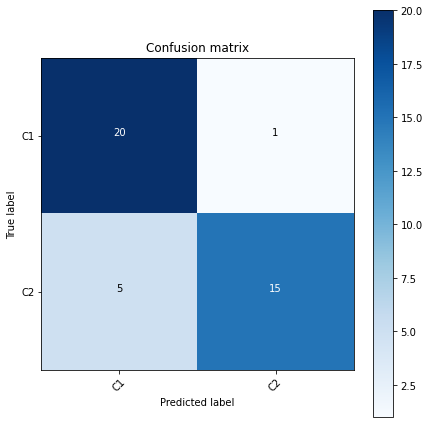

In [45]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=False)

from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

predicted = model.predict(x_test)
for i in range(len(predicted)):
    predicted[i] = np.around(predicted[i])
    
recall = recall_score(y_test, predicted, average=None)
precision = precision_score(y_test, predicted, average=None)
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted,  average=None)

print("Accuracy:\t", round(accuracy, 5))
print("Recall:\t\t", round(recall[0] ,5 ), '\t', round(recall[1] ,5 ))
print("Precision:\t", round(precision[0] ,5 ), '\t\t', round(precision[1] ,5 ))
print("F1:\t\t", round(f1[0] ,5 ), '\t', round(f1[1] ,5 ))

In [24]:
model.save('my_model/top_model.h5')